In [ ]:
# This code is used to train an ML model on light curves for 9 limb darkening cases
# simultaneously [a,b] =[0.1,0.5] to [0.9,0.5]

In [1]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
import sys
from numpy import array,append,arange,zeros,exp,sin,random,std
from scipy.interpolate import interp1d

2023-11-13 11:55:15.890695: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 11:55:16.868821: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [2]:
tf.keras.backend.clear_session()

In [3]:
# 1. Load Dataset
## Load Train Set
train_shape_dir = '/scratch/abraham/Documents/mega_git/mega/data/train/npy/shape/train_shape_5_9times.npy'
train_lc_dir = '/scratch/abraham/Documents/mega_git/mega/data/train/npy/lc/train_lc_1_to_9.npy'
train_lc = np.load(train_lc_dir)
train_shape = np.load(train_shape_dir)
# Check equality of number of dataset
print('train_lc.shape =',train_lc.shape)
print('train_shape.shape = ',train_shape.shape)
if len(train_lc)==len(train_shape):
    print("Train Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: Train Set: No. of LC != No. of shapes")

## Load Validation Set
vald_shape_dir = '/scratch/abraham/Documents/mega_git/mega/data/vald/npy/shape/vald_shape_1_9times.npy'
vald_lc_dir = '/scratch/abraham/Documents/mega_git/mega/data/vald/npy/lc/vald_lc_1_to_9.npy'
vald_lc = np.load(vald_lc_dir)
vald_shape = np.load(vald_shape_dir)
# Check equality of nuftmber of dataset
print('vald_lc.shape =',vald_lc.shape)
print('vald_shape.shape = ',vald_shape.shape)
if len(vald_lc)==len(vald_shape):
    print("Vald Set: No. of LC = No. of shapes")
else:
    sys.exit("Vald Set: No. of LC = No. of shapes")

train_lc.shape = (1189224, 100)
train_shape.shape =  (1189224, 38, 38)
Train Set: No. of LC = No. of shapes
vald_lc.shape = (9000, 100)
vald_shape.shape =  (9000, 38, 38)
Vald Set: No. of LC = No. of shapes


In [4]:
# 2. Normalize the image, convert to opacity map
## Train Set
train_shape = train_shape/np.amax(train_shape)
train_shape_where_0 = np.where(train_shape == 0)
train_shape_where_1 = np.where(train_shape == 1)
train_shape[train_shape_where_0] = 1  # 1 represent the shape (1 opacity)
train_shape[train_shape_where_1] = 0  # 0 represent background (0 opacity)

## Valdn Set
vald_shape = vald_shape/np.amax(vald_shape)
vald_shape_where_0 = np.where(vald_shape == 0)
vald_shape_where_1 = np.where(vald_shape == 1)
vald_shape[vald_shape_where_0] = 1  # 1 represent the shape (1 opacity)
vald_shape[vald_shape_where_1] = 0  # 0 represent background (0 opacity)
print("Normalized the shape")


Normalized the shape


In [5]:
# 2. Normalize the lightcurves
## - Train Set
train_lc_scaled = np.zeros(train_lc.shape)
for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled[i] = (train_lc[i] - np.amin(train_lc[i]))/(np.amax(train_lc[i]) - np.amin(train_lc[i]))

## - Vald Set
vald_lc_scaled = np.zeros(vald_lc.shape)
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled[i] = (vald_lc[i] - np.amin(vald_lc[i]))/(np.amax(vald_lc[i]) - np.amin(vald_lc[i]))
print("Normalized the light curves")


Normalized the light curves


In [6]:
# Add flat line towards left and right of dip
# 10 data points on each side
# 3. Extend the lightcurves
## - Train Set
train_lc_scaled_append = np.ones((train_lc.shape[0],120))
print('train_lc_scaled_append.shape = ',train_lc_scaled_append.shape)
print("len(train_lc_scaled_append[0,10:110]) = ",len(train_lc_scaled_append[0,10:110]))

for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled_append[i,10:110] = train_lc_scaled[i]

## - Vald Set
vald_lc_scaled_append = np.ones((vald_lc.shape[0],120))
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled_append[i,10:110] = vald_lc_scaled[i]
print("Extended the light curves")

train_lc_scaled_append.shape =  (1189224, 120)
len(train_lc_scaled_append[0,10:110]) =  100
Extended the light curves


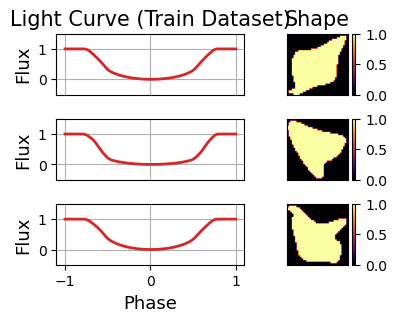

In [7]:
# Verification
# Plot - Train LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(train_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(train_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, train_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

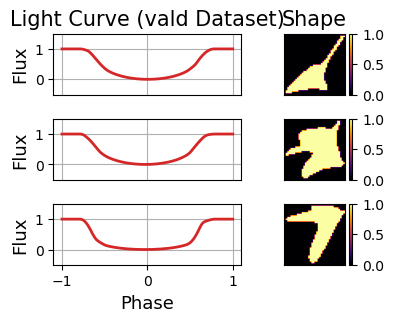

In [8]:
# Verification
# Plot - vald LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (vald Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(vald_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(vald_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(vald_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, vald_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

In [9]:
# Array of number of datapoints to sample
rng = np.random.default_rng()
train_sample_Ndatapoints = rng.integers(20,60,len(train_lc_scaled_append))
vald_sample_Ndatapoints = rng.integers(20,60,len(vald_lc_scaled_append))

print('train_sample_Ndatapoints[0:10] = ',train_sample_Ndatapoints[0:10])
print('vald_sample_Ndatapoints[0:10] = ',vald_sample_Ndatapoints[0:10])

train_sample_Ndatapoints[0:10] =  [55 53 23 29 23 23 25 34 36 37]
vald_sample_Ndatapoints[0:10] =  [35 57 54 30 26 45 49 56 26 43]


In [10]:
# # (1) Interpolate Train light curve and 
# # (2) sample at different datapoints

# train_lc_scaled_interpol = np.zeros((len(train_lc_scaled_append),len(train_lc_scaled_append[0])))
# print('train_lc_scaled_interpol.shape = ',train_lc_scaled_interpol.shape)


# for iteration in np.arange(len(train_lc_scaled_interpol)):
#     ## 1. Select x number of datapoints
#     # Original data with 120 elements
#     original_x = np.linspace(-1, 1, num=len(train_lc_scaled_append[iteration]))
#     original_y = train_lc_scaled_append[iteration]  

#     # Create a quadratic interpolation function
#     f = interp1d(original_x, original_y, kind='quadratic')

#     # Define the range of x-values for the interpolation with 'train_sample_Ndatapoints elements
#     x_interpolation = np.linspace(-1, 1, num=train_sample_Ndatapoints[iteration])

#     # Perform the interpolation
#     y_interpolated = f(x_interpolation)
    
#     ## 2. Interpolate back to 120
#     original_x = np.linspace(-1, 1, num=len(y_interpolated))
#     original_y = y_interpolated  

#     # Create a quadratic interpolation function
#     f = interp1d(original_x, original_y, kind='quadratic')

#     # Define the range of x-values for the interpolation with 120 elements
#     x_interpolation = np.linspace(-1, 1, num=120)

#     # Perform the interpolation
#     y_interpolated = f(x_interpolation)


#     train_lc_scaled_interpol[iteration] = y_interpolated

In [11]:
# This code is used to sample the simulated lc for the given number of datapoints
# Mainly for plotting purpose
def sample_simul_lc(simulated_lc,sample_Ndatapoints):
    original_x = np.linspace(-1, 1, num=len(simulated_lc))
    original_y = simulated_lc

    # Create a quadratic interpolation function
    f = interp1d(original_x, original_y, kind='quadratic')

    # Define the range of x-values for the interpolation with 'train_sample_Ndatapoints elements
    x_interpolation = np.linspace(-1, 1, num=sample_Ndatapoints)

    # Perform the interpolation
    y_interpolated = f(x_interpolation)
    return(x_interpolation,y_interpolated)

In [12]:
# (1) Interpolate Train light curve and 
# (2) sample at different datapoints
def sample_interpolate_simul_lc(simulated_lc,sample_Ndatapoints_array):
    simulated_lc_interpol = np.zeros((len(simulated_lc),len(simulated_lc[0])))
    print('simulated_lc_interpol.shape = ',simulated_lc_interpol.shape)


    for iteration in np.arange(len(simulated_lc_interpol)):
        ## 1. Select x number of datapoints
        # Original data with 120 elements
        original_x = np.linspace(-1, 1, num=len(simulated_lc[iteration]))
        original_y = simulated_lc[iteration]  

        # Create a quadratic interpolation function
        f = interp1d(original_x, original_y, kind='quadratic')

        # Define the range of x-values for the interpolation with 'train_sample_Ndatapoints elements
        x_interpolation = np.linspace(-1, 1, num=sample_Ndatapoints_array[iteration])

        # Perform the interpolation
        y_interpolated = f(x_interpolation)
        
        ## 2. Interpolate back to 120
        original_x = np.linspace(-1, 1, num=len(y_interpolated))
        original_y = y_interpolated  

        # Create a quadratic interpolation function
        f = interp1d(original_x, original_y, kind='quadratic')

        # Define the range of x-values for the interpolation with 120 elements
        x_interpolation = np.linspace(-1, 1, num=len(simulated_lc[0]))

        # Perform the interpolation
        y_interpolated = f(x_interpolation)


        simulated_lc_interpol[iteration] = y_interpolated
    return(simulated_lc_interpol)
    
train_lc_scaled_interpol = sample_interpolate_simul_lc(simulated_lc=train_lc_scaled_append,sample_Ndatapoints_array=train_sample_Ndatapoints)
vald_lc_scaled_interpol = sample_interpolate_simul_lc(simulated_lc=vald_lc_scaled_append,sample_Ndatapoints_array=vald_sample_Ndatapoints)

simulated_lc_interpol.shape =  (1189224, 120)
simulated_lc_interpol.shape =  (9000, 120)


In [13]:
def size_in_mb(arr):
    return arr.nbytes / (1024 * 1024)
size_mb = size_in_mb(train_lc_scaled_interpol)
print(f"Size of train_lc_scaled_interpol NumPy array: {size_mb:.2f} MB")
size_mb = size_in_mb(vald_lc_scaled_interpol)
print(f"Size of vald_lc_scaled_interpol NumPy array: {size_mb:.2f} MB")

Size of train_lc_scaled_interpol NumPy array: 1088.77 MB
Size of vald_lc_scaled_interpol NumPy array: 8.24 MB


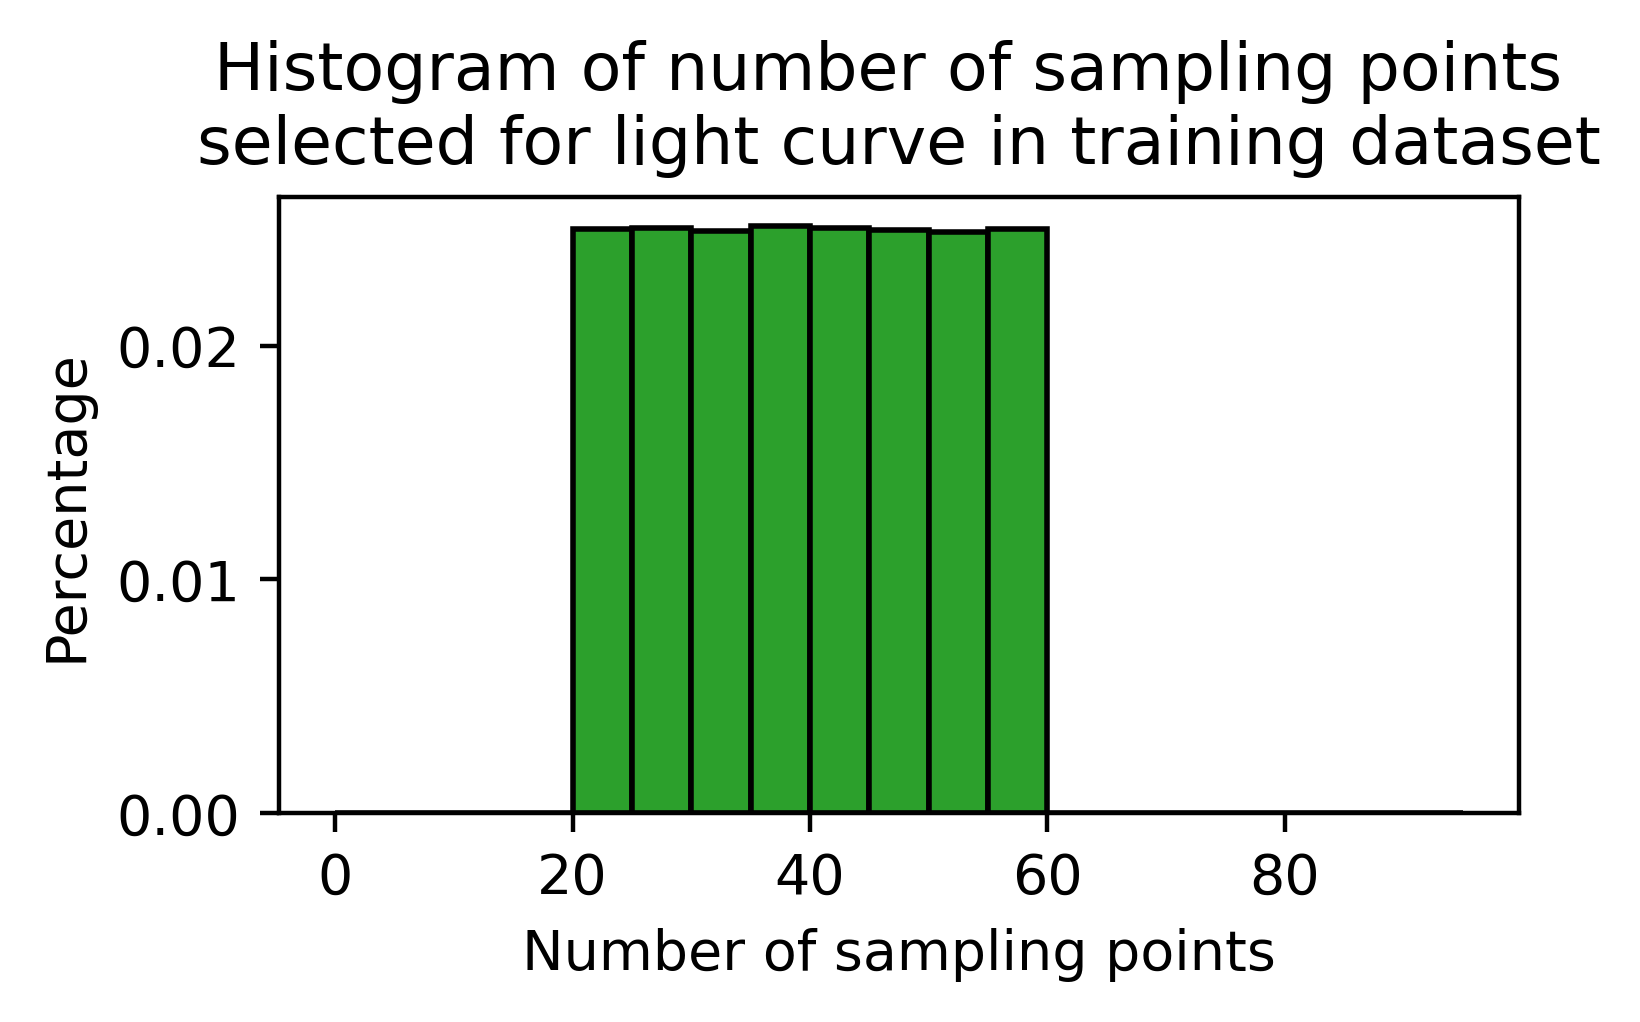

In [14]:
# Create a histogram for Number of sample points for training set

plt.rcParams['figure.dpi'] = 400
plt.figure(figsize=(4, 2))  # Adjust the width and height as needed

plt.hist(train_sample_Ndatapoints, density=True, bins=np.arange(0,100,5), color='tab:green', edgecolor='black')

# Add labels and a title
plt.xlabel('Number of sampling points')
plt.ylabel('Percentage')
plt.title('Histogram of number of sampling points \nselected for light curve in training dataset')

# Display the histogram
plt.show()

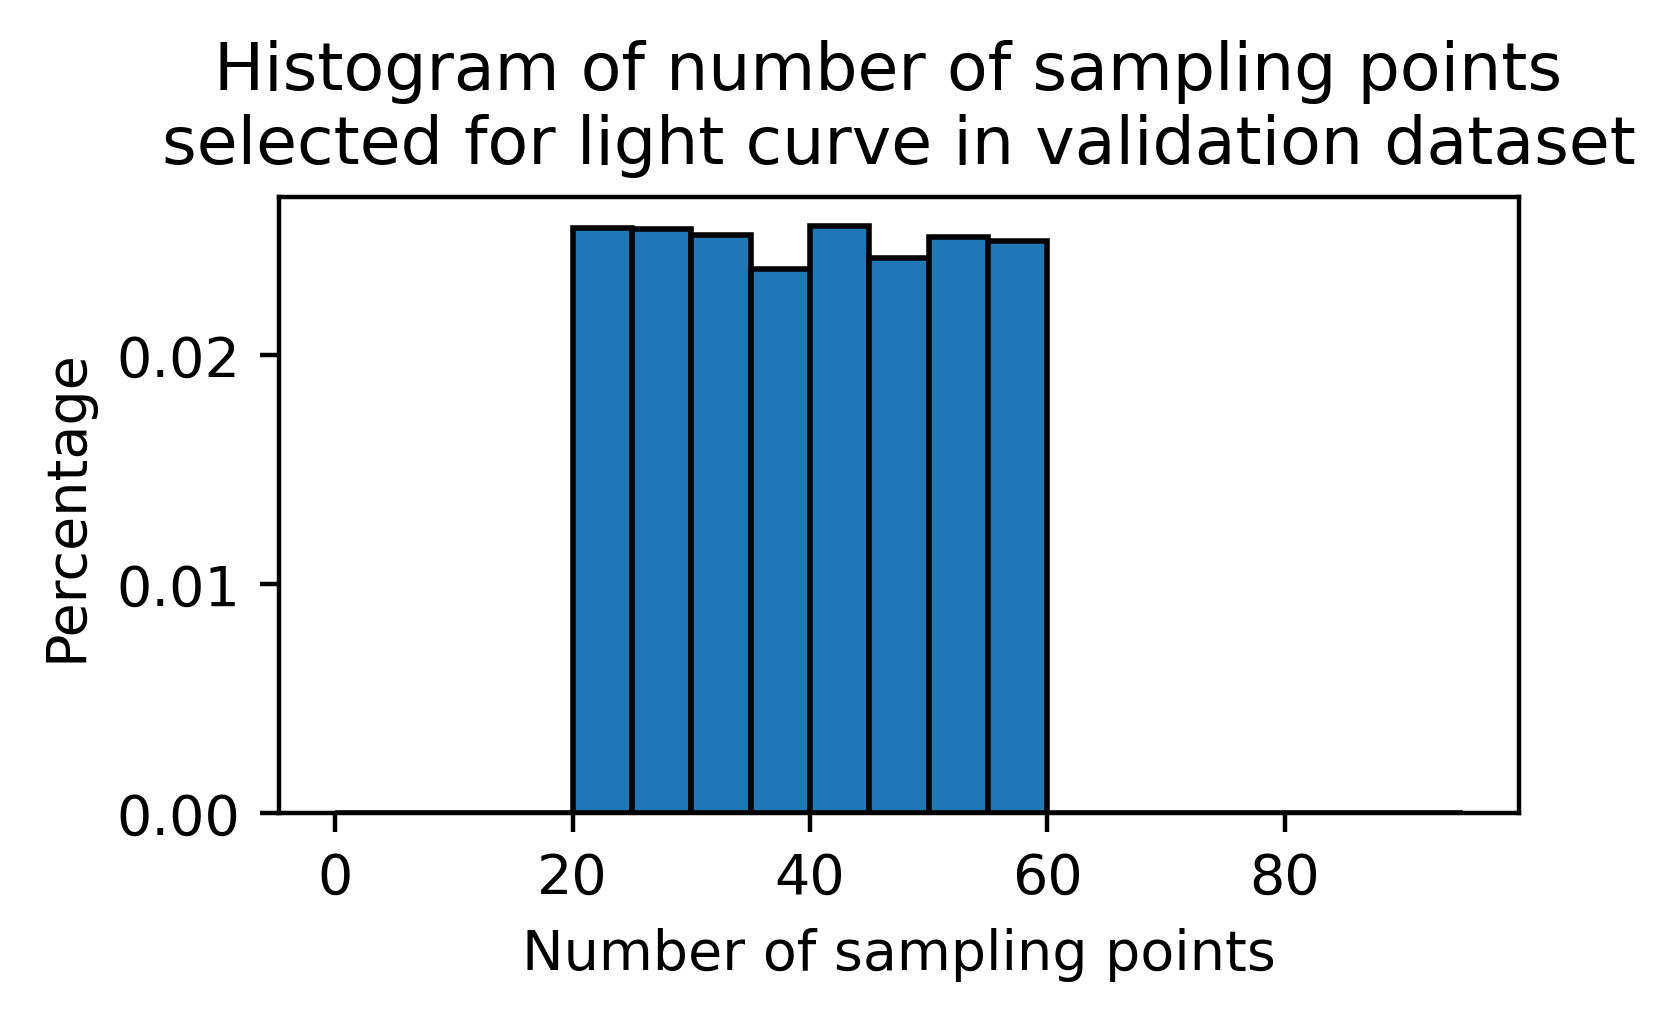

In [15]:
# Create a histogram for Number of sample points for validation set

plt.rcParams['figure.dpi'] = 400
plt.figure(figsize=(4, 2))  # Adjust the width and height as needed
plt.hist(vald_sample_Ndatapoints, density=True, bins=np.arange(0,100,5), color='tab:blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Number of sampling points')
plt.ylabel('Percentage')
plt.title('Histogram of number of sampling points \nselected for light curve in validation dataset')

# Display the histogram
plt.show()

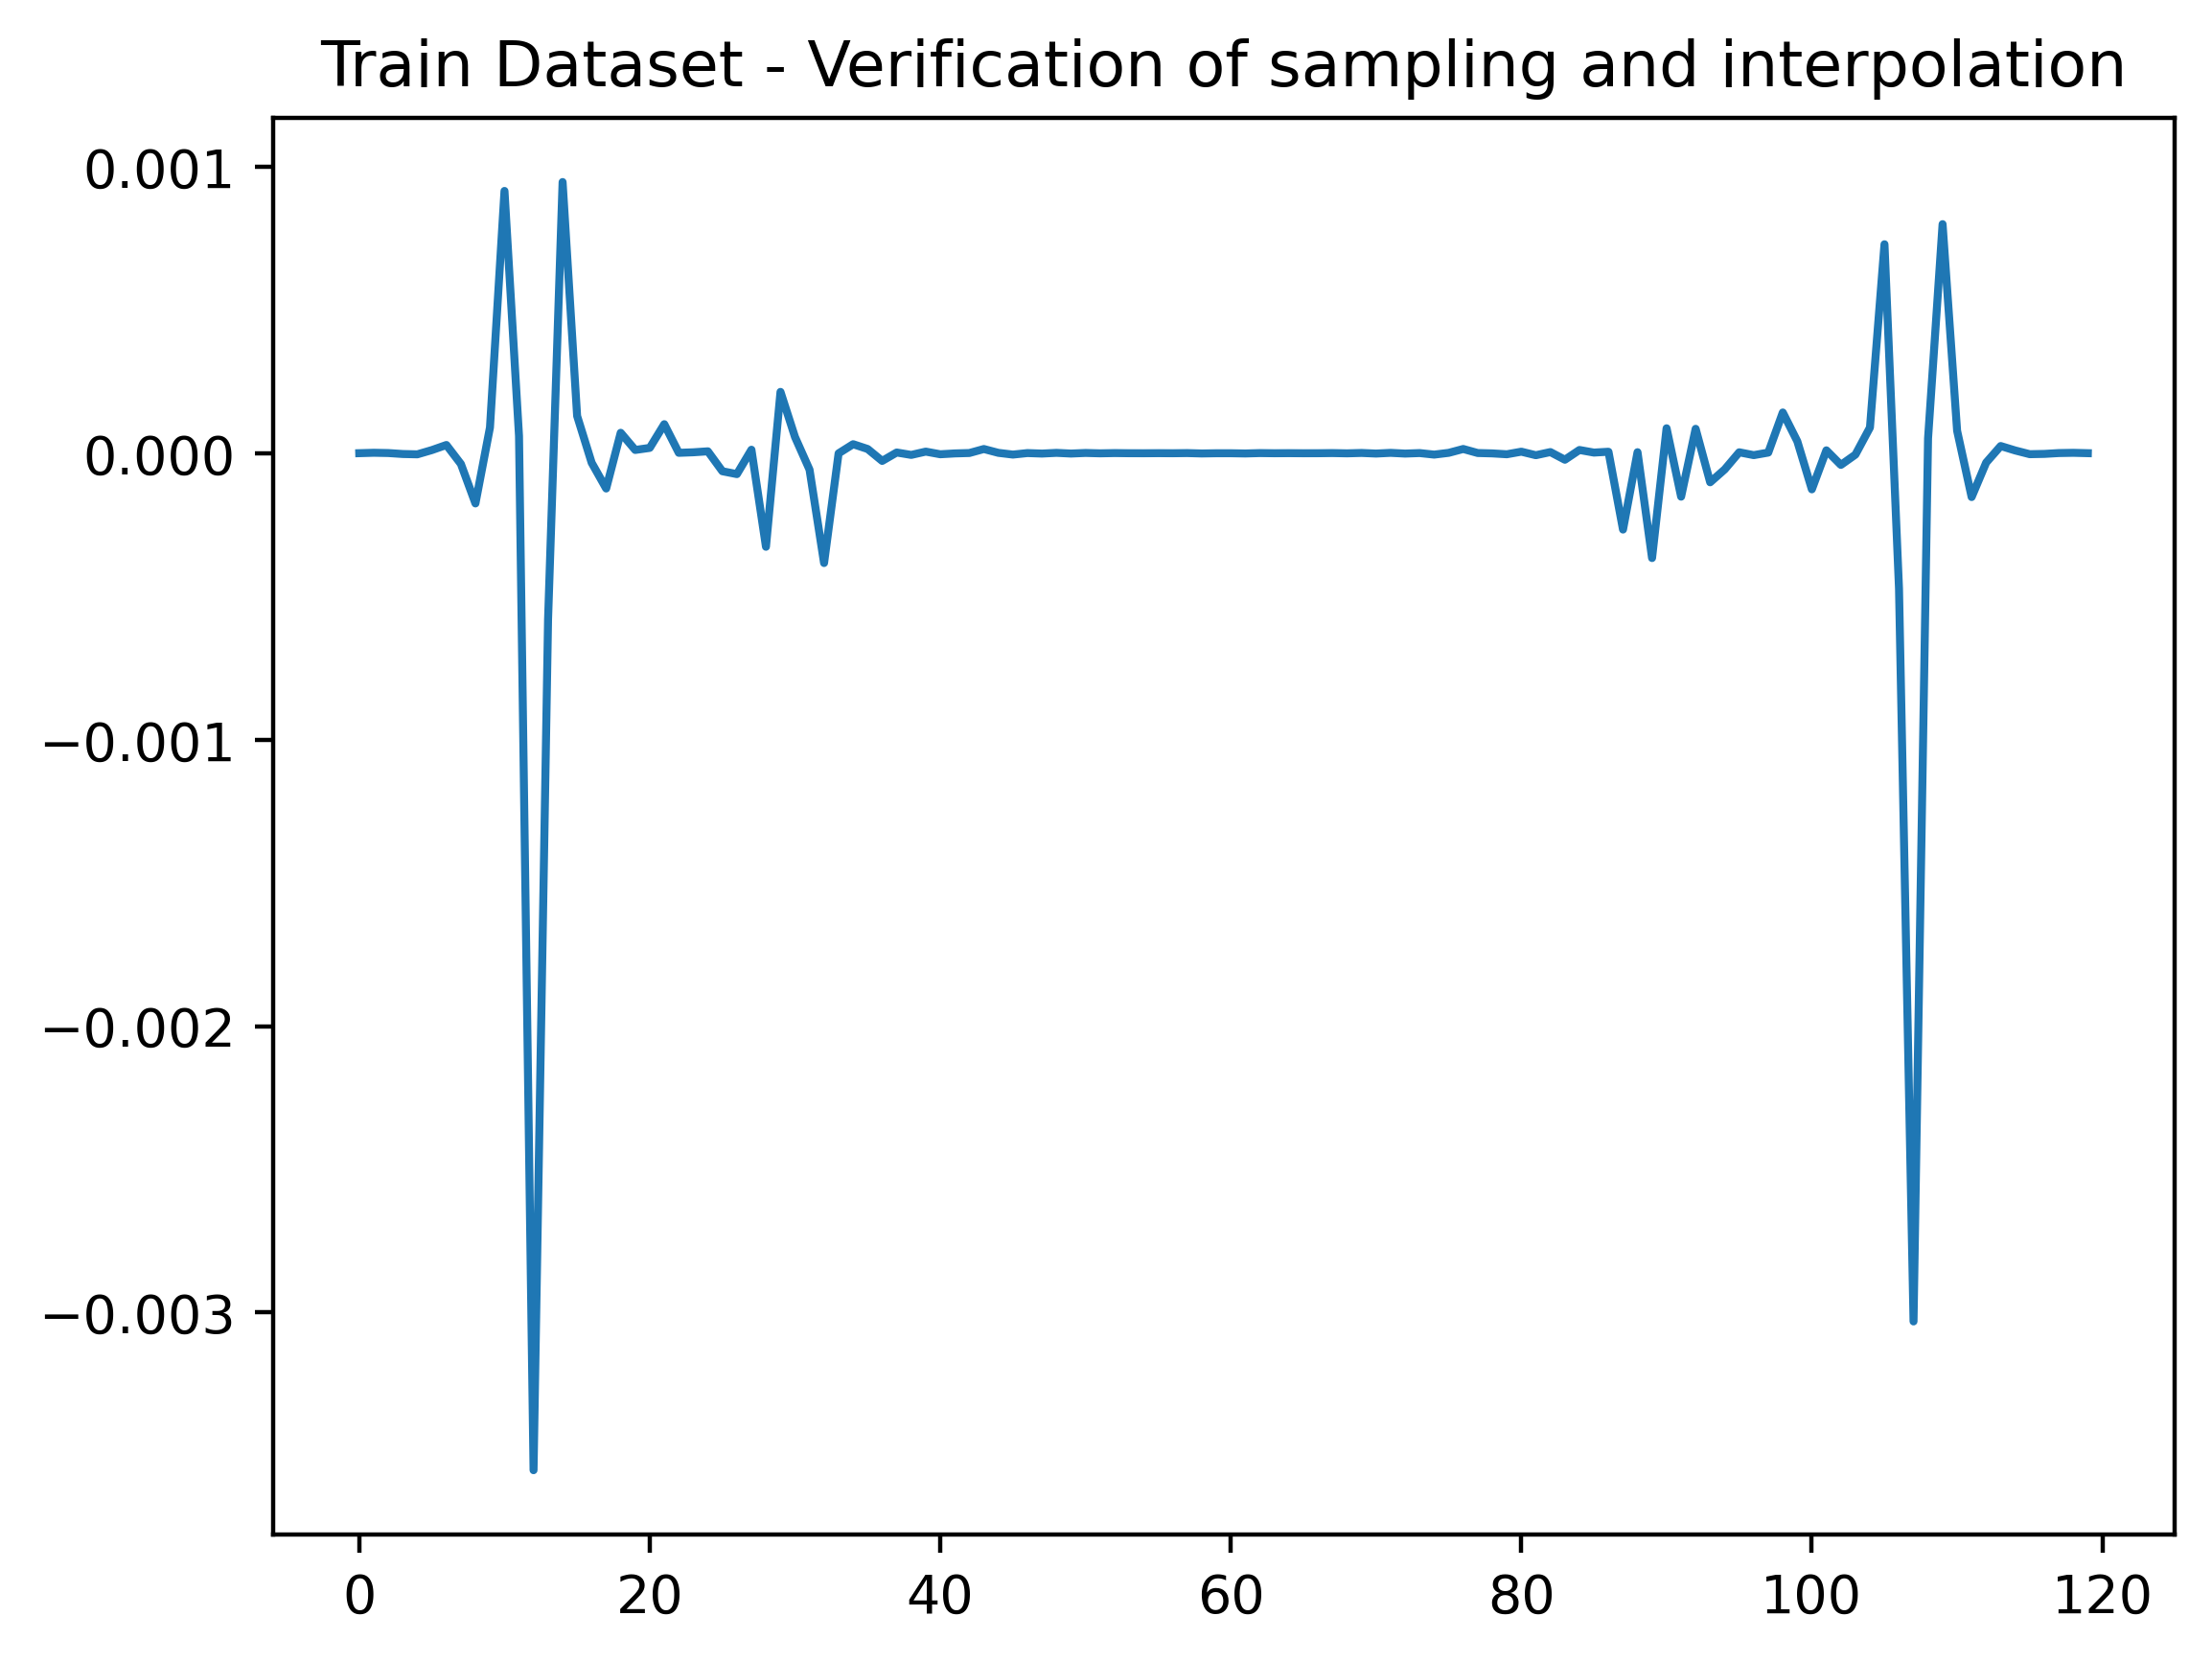

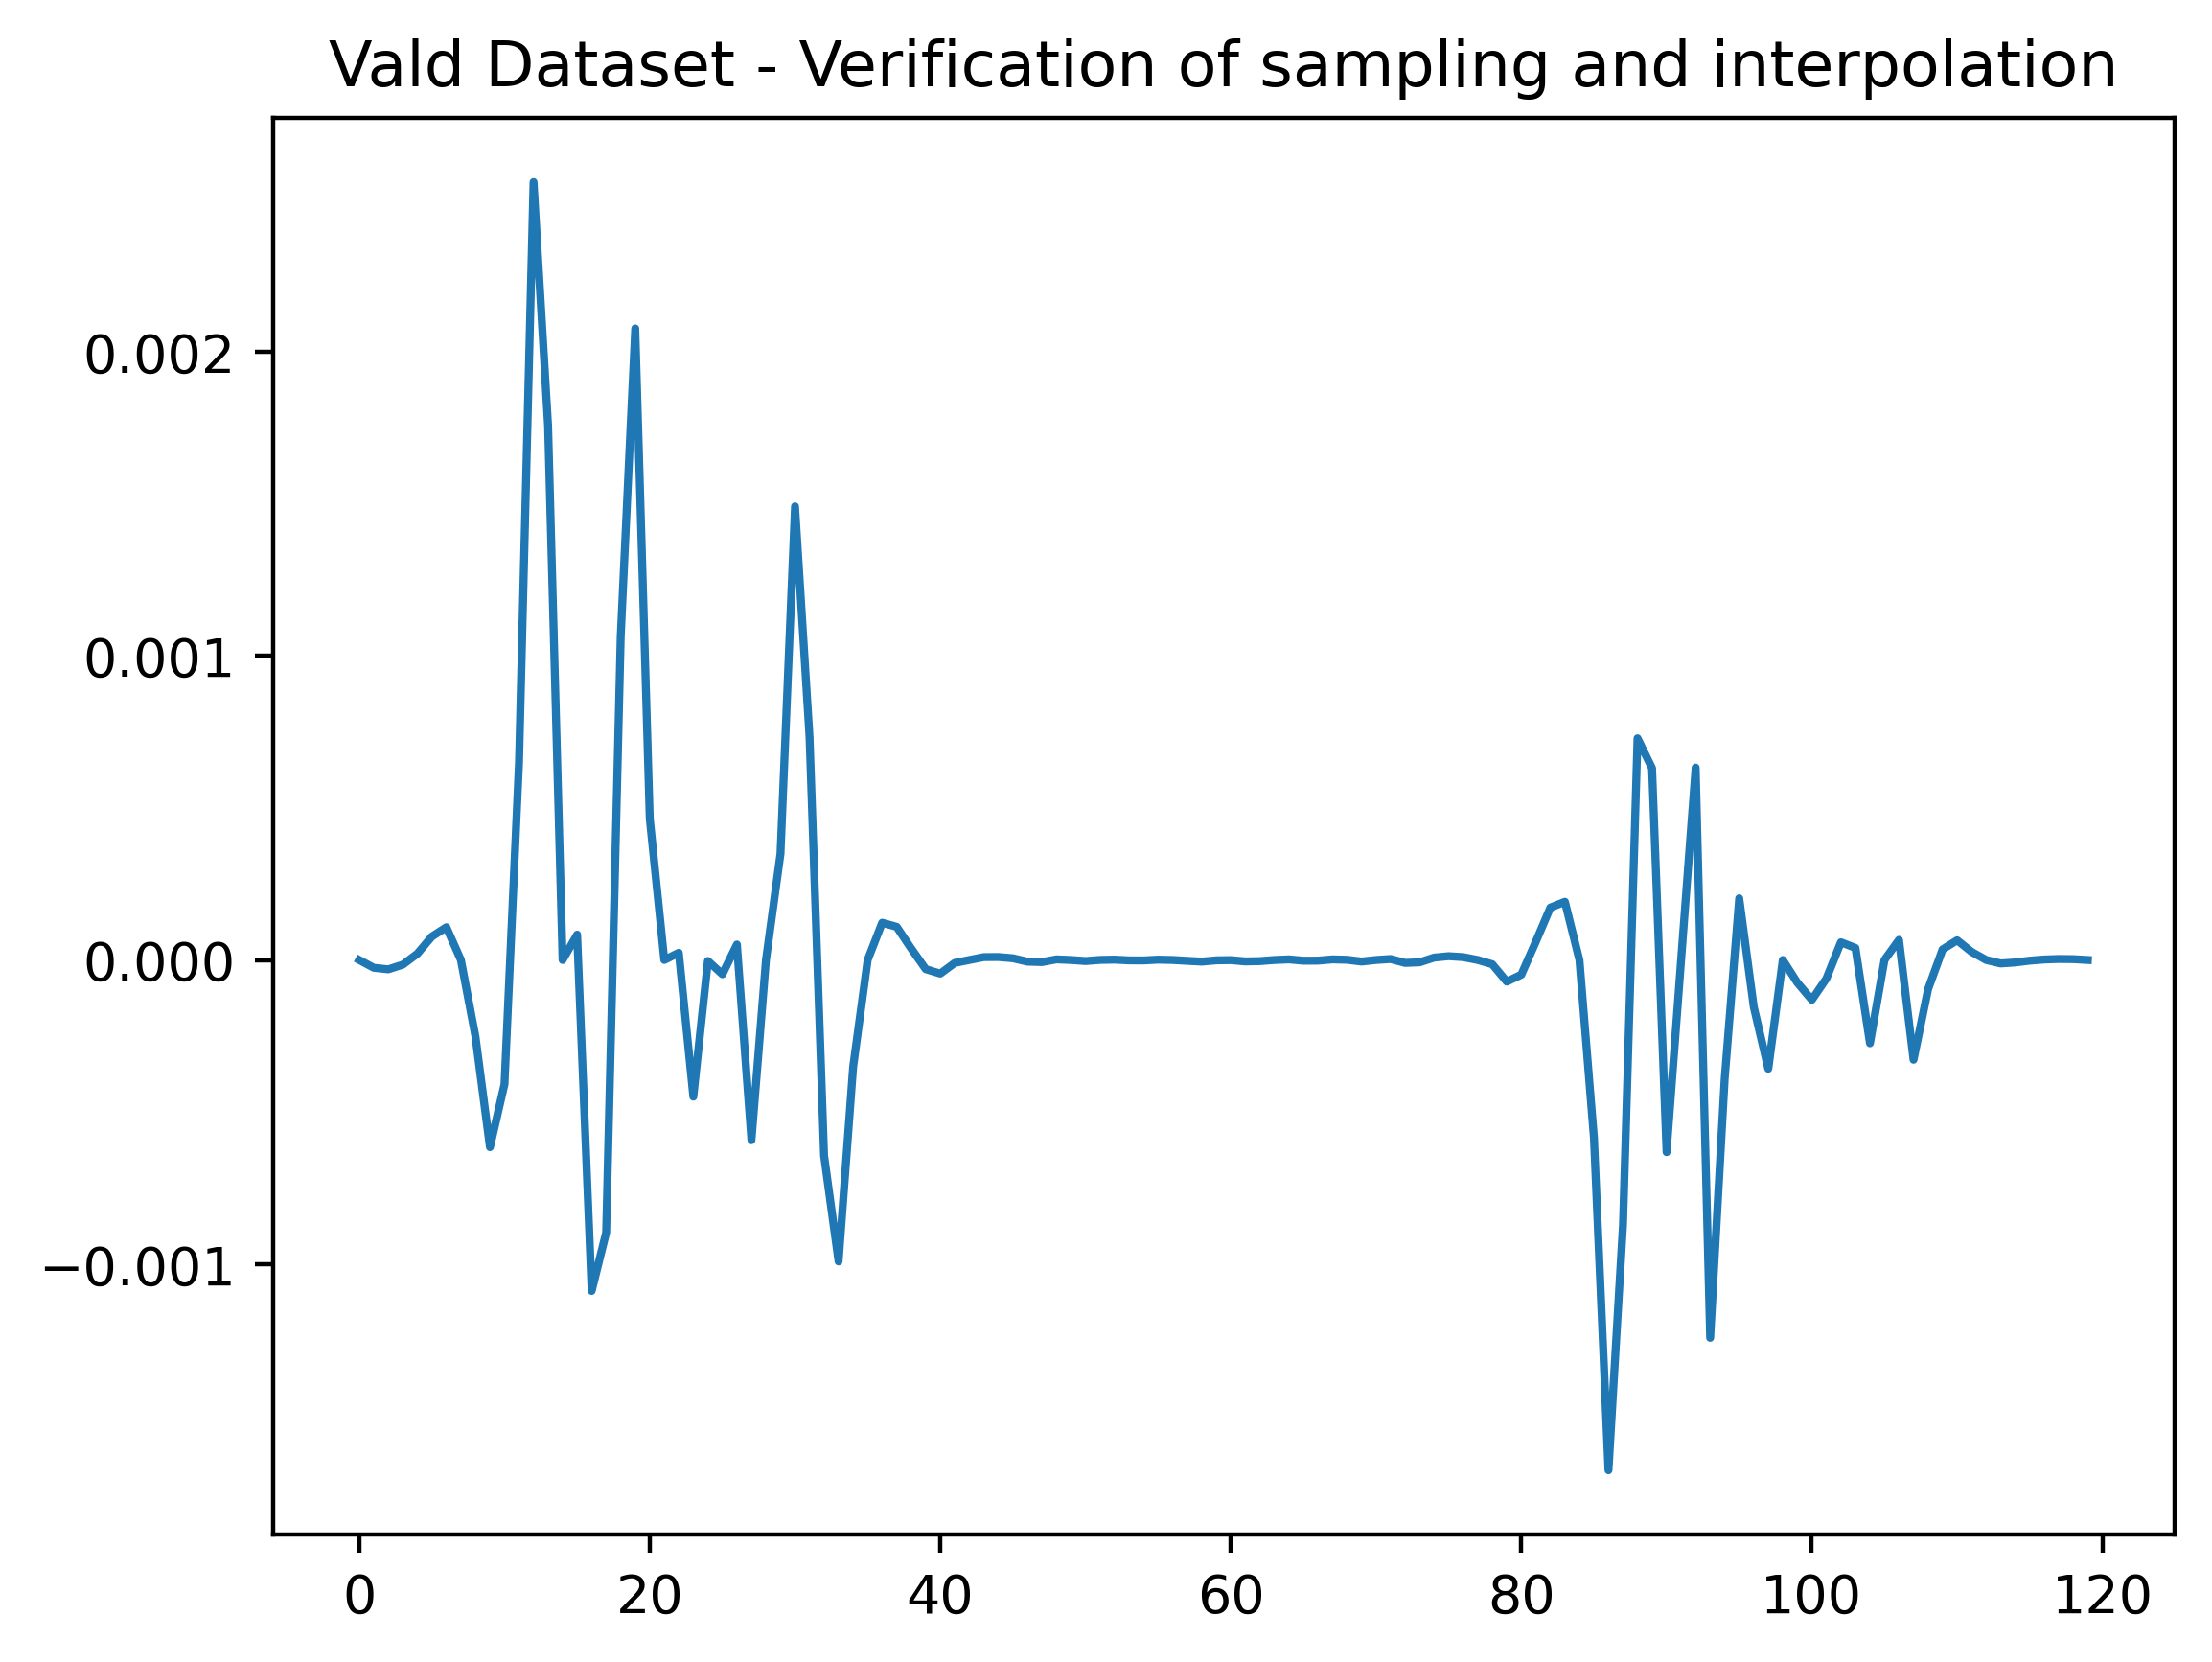

In [16]:
# Verification of sampling and interpolation
# Train Dataset
plt.title('Train Dataset - Verification of sampling and interpolation')
plt.plot(train_lc_scaled_interpol[0]-train_lc_scaled_append[0])
plt.show()

# Vald Dataset
plt.title('Vald Dataset - Verification of sampling and interpolation')
plt.plot(vald_lc_scaled_interpol[0]-vald_lc_scaled_append[0])
plt.show()

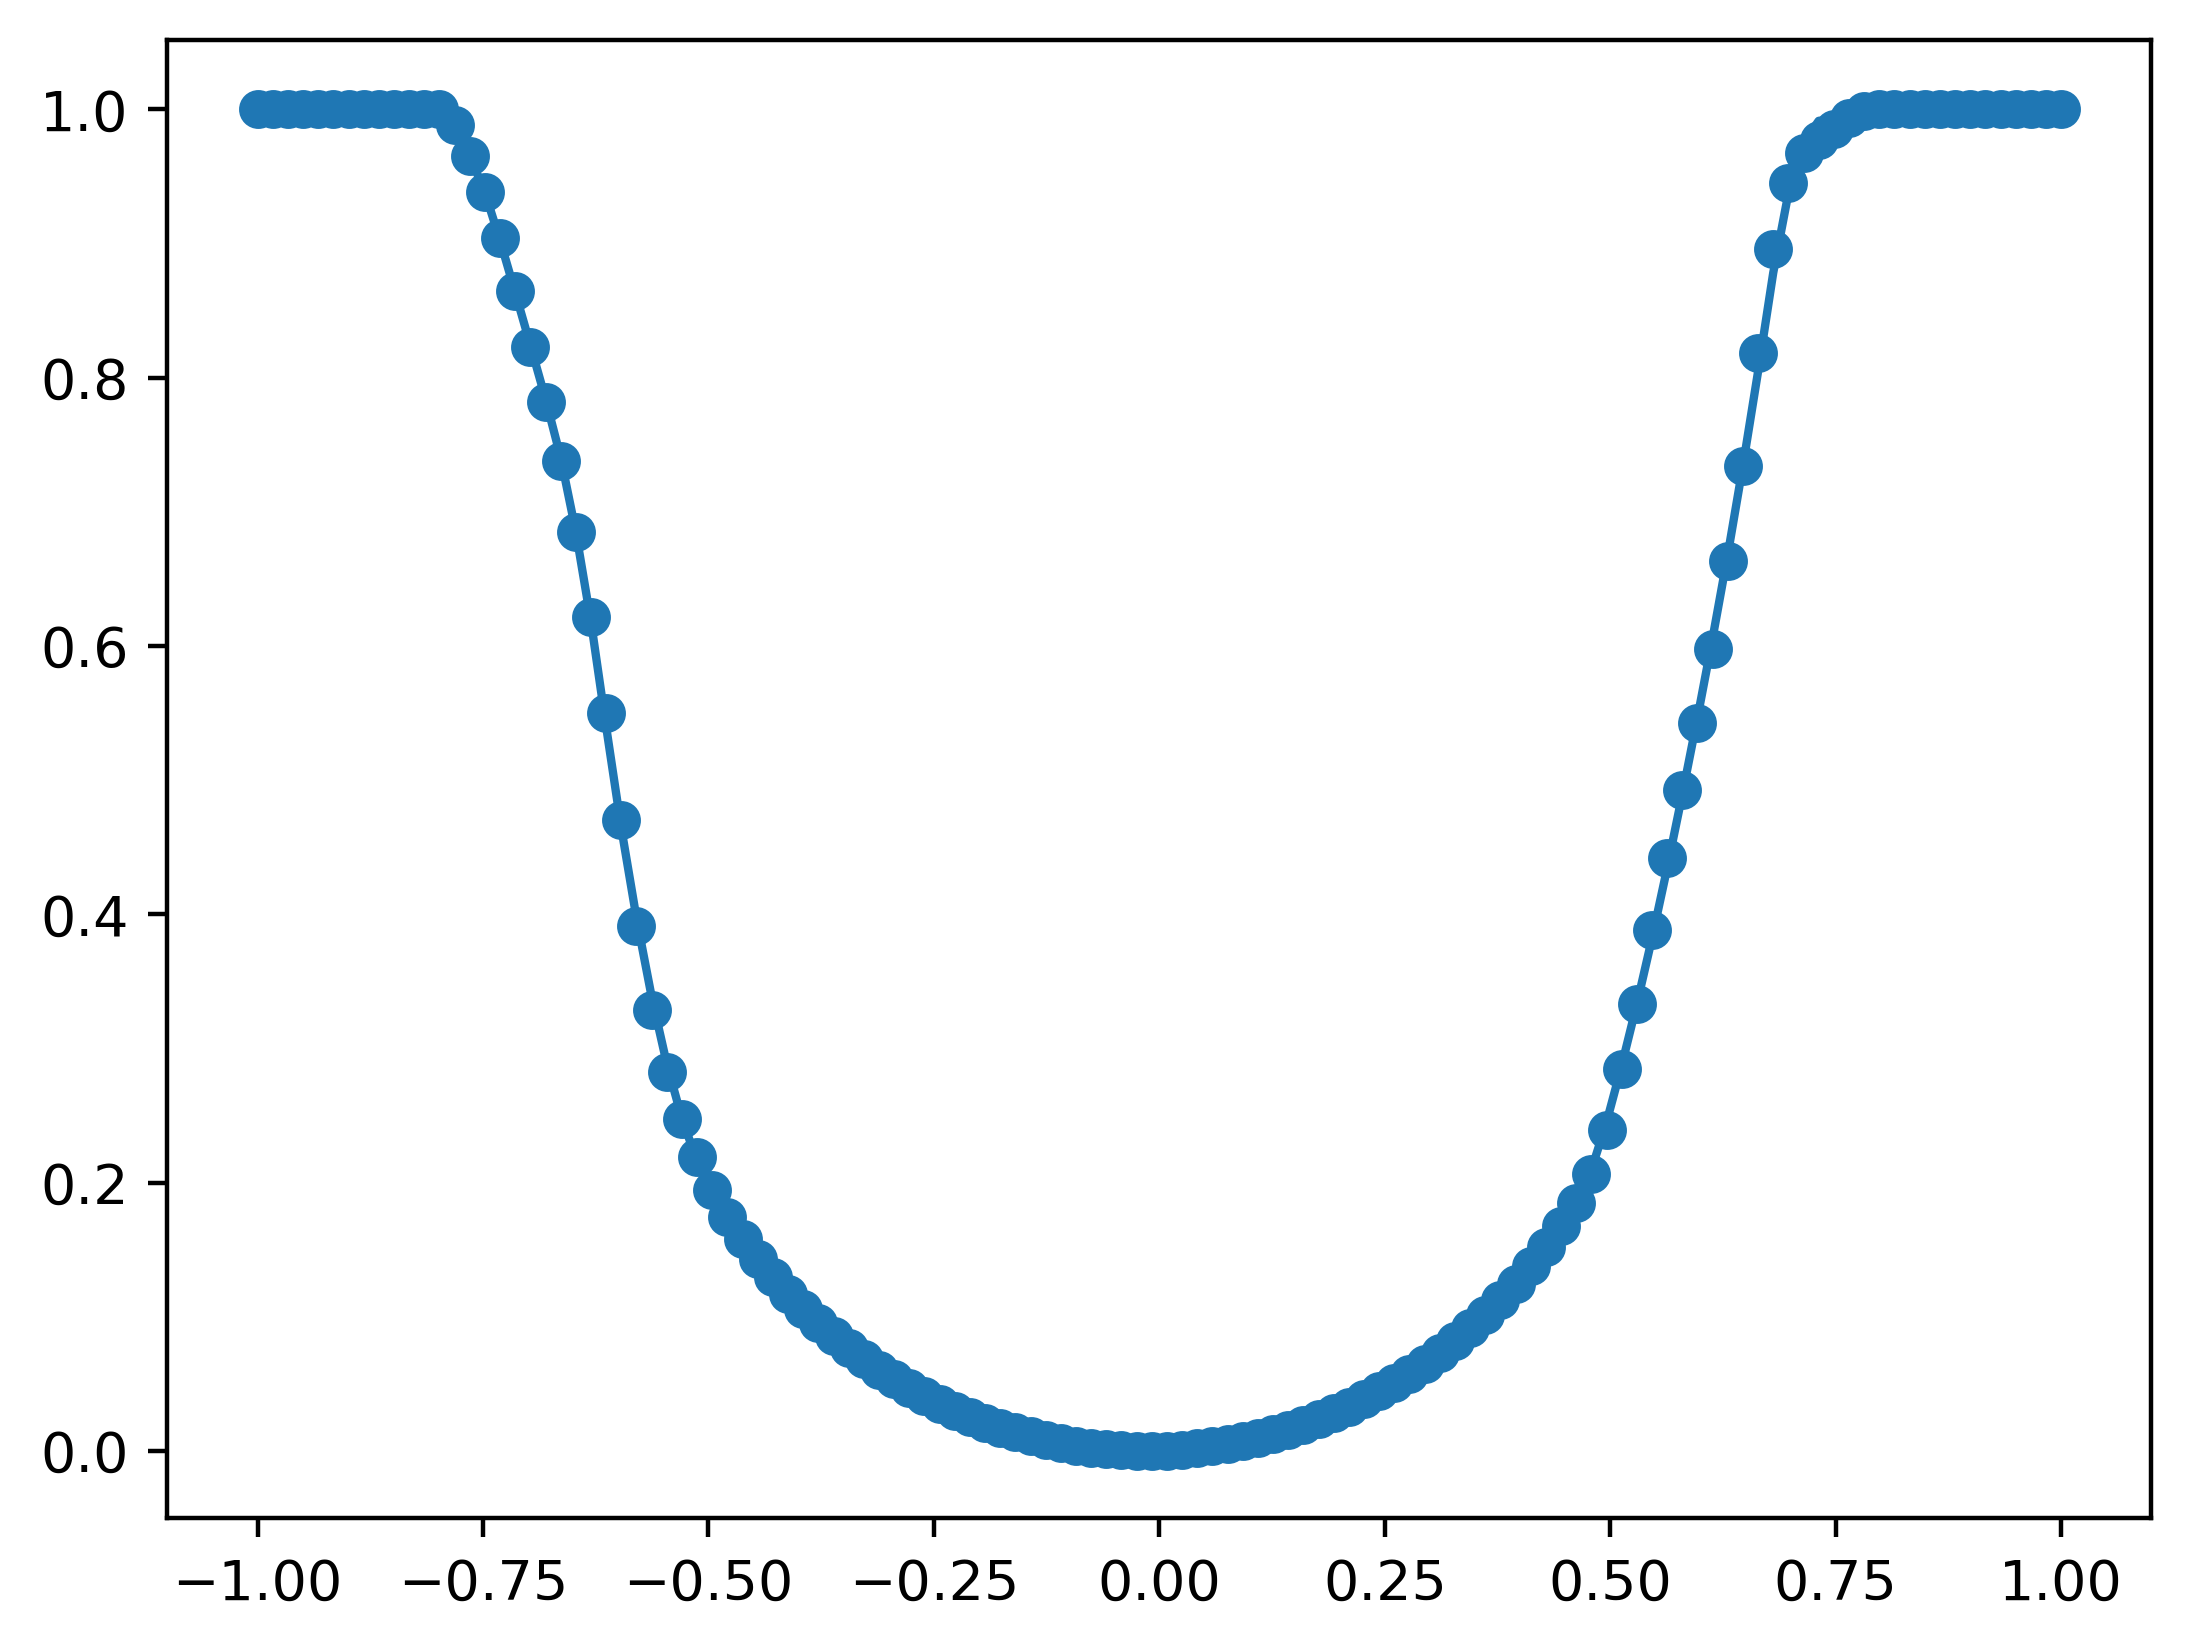

In [17]:
plt.plot(np.linspace(-1,1,len(train_lc_scaled_interpol[5000])),train_lc_scaled_interpol[5000])
plt.scatter(np.linspace(-1,1,len(train_lc_scaled_append[5000])),train_lc_scaled_append[5000])
plt.show()

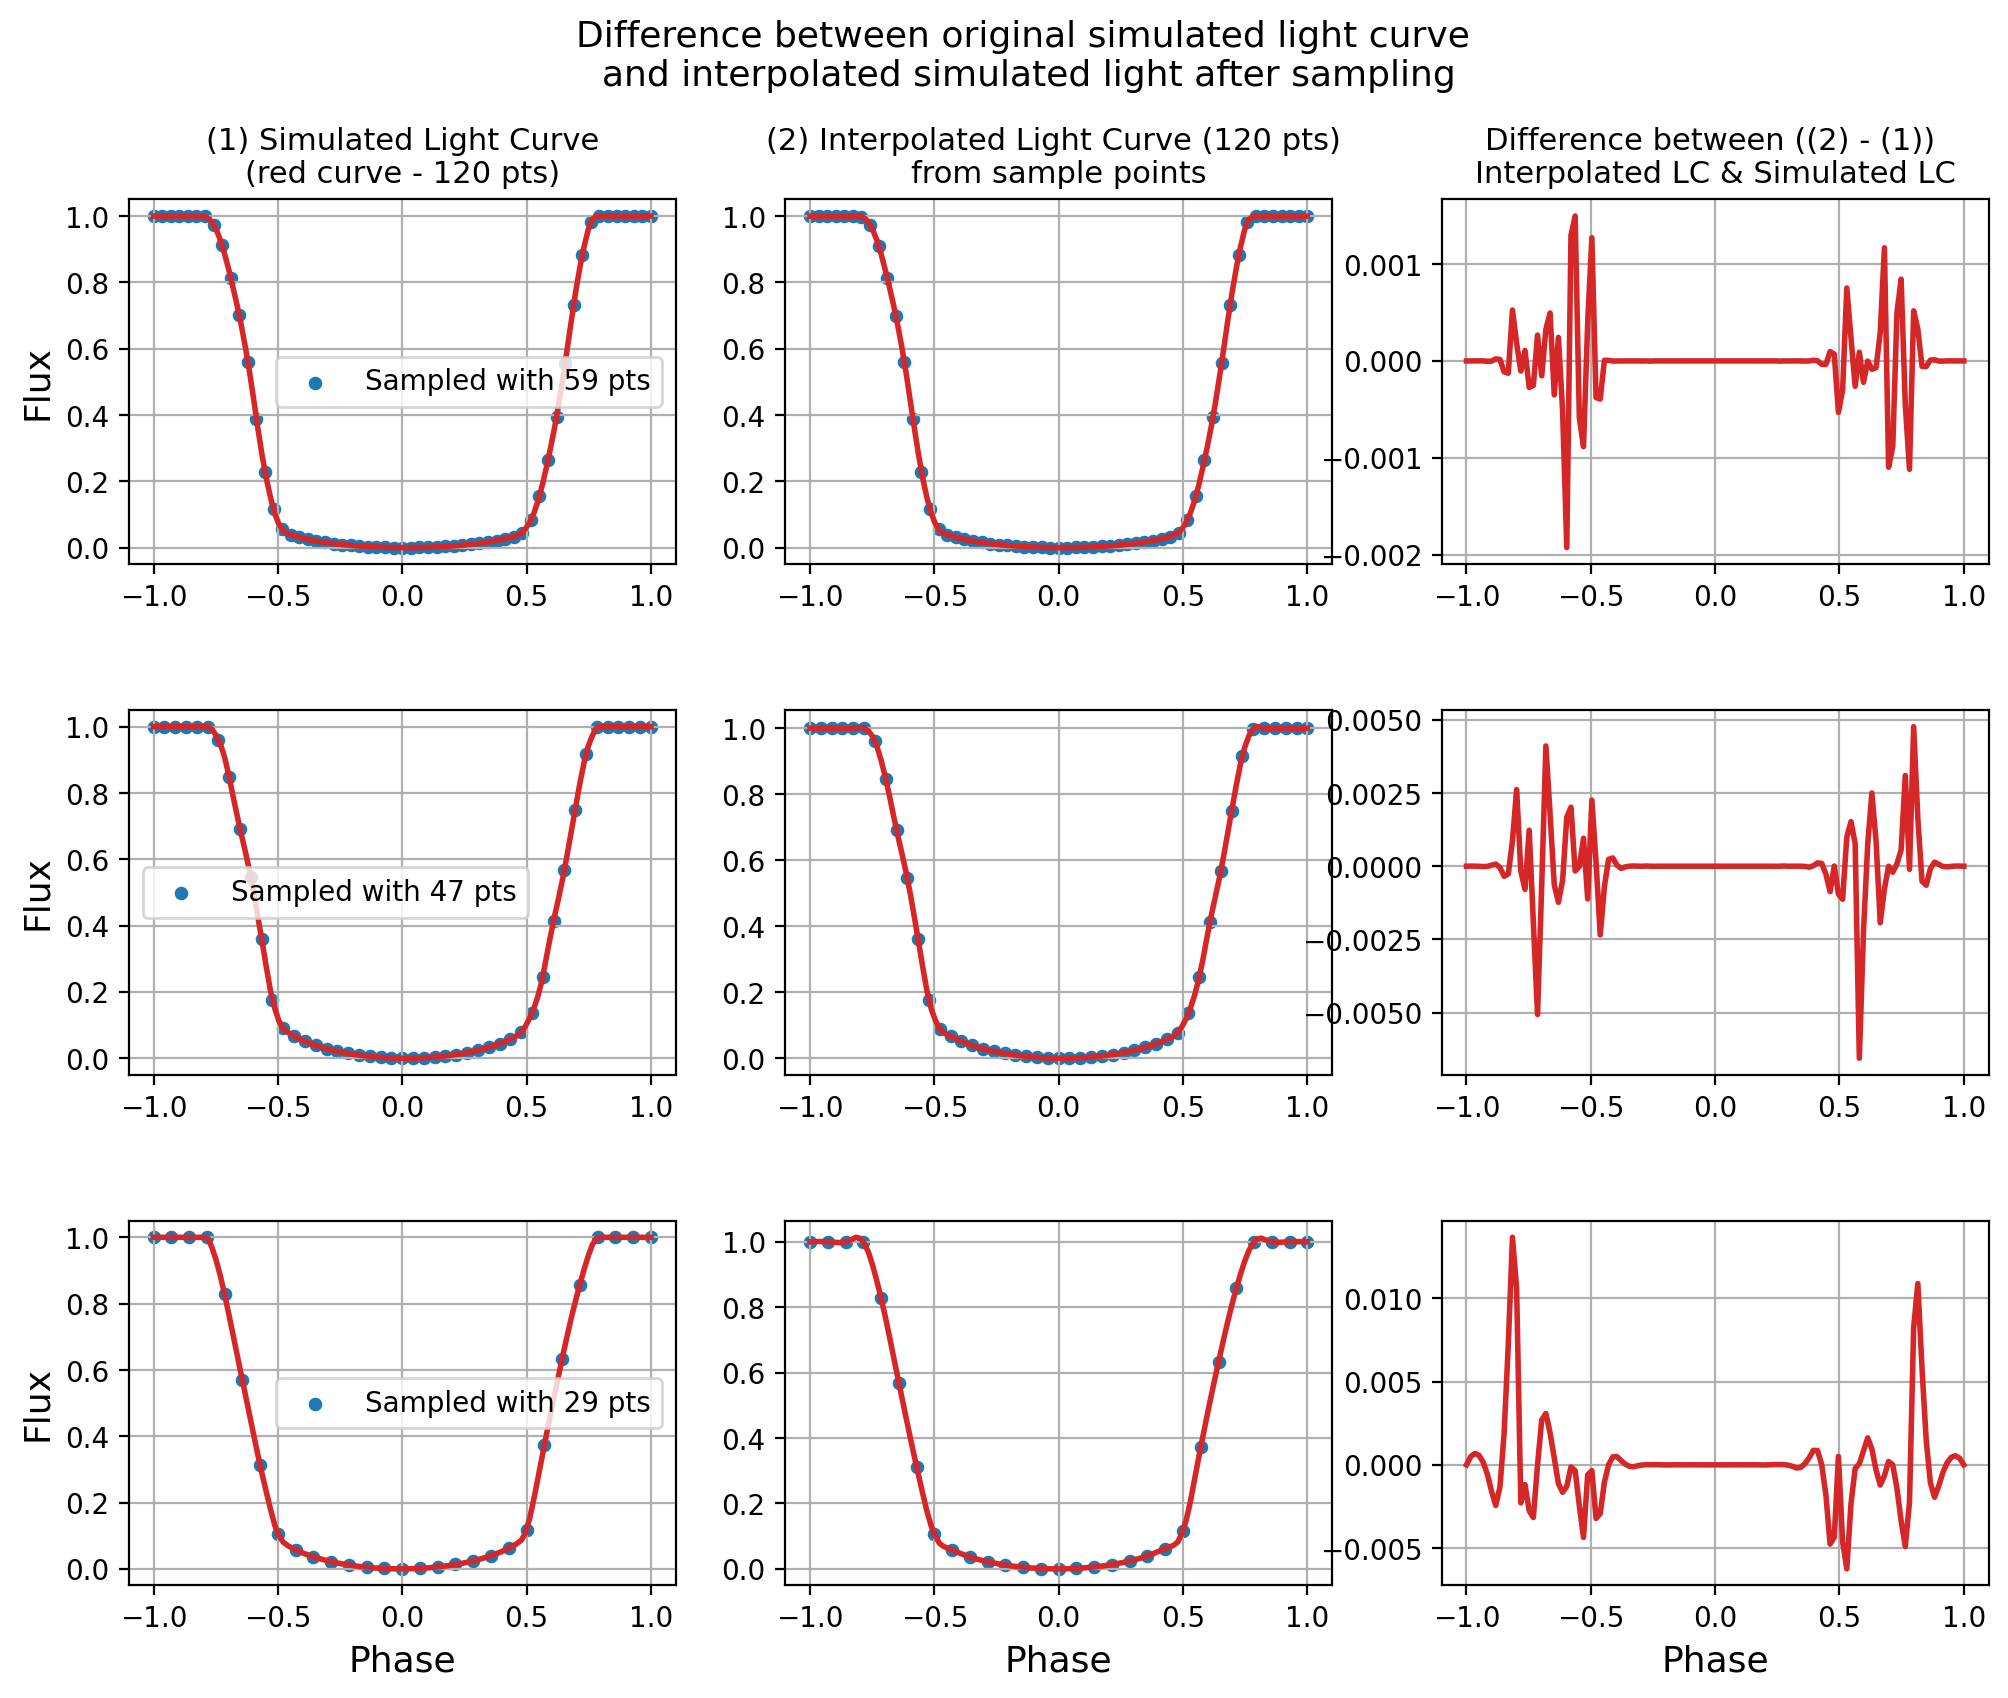

In [18]:
# Plot -
# (1) Simulated LC + Sampled Datapoints
# (2) Interpolated LC from Sample Datapoints
# (3) Difference between simulated LC and interpolated simulated LC
num = 3
plt.rcParams['figure.dpi'] = 200

fig,ax=plt.subplots(num,3, figsize=(12,9), gridspec_kw={ 'width_ratios': [1,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][0].set_title('(1) Simulated Light Curve\n(red curve - 120 pts)',size=11)
ax[0][1].set_title('(2) Interpolated Light Curve (120 pts) \nfrom sample points',size=11)
ax[0][2].set_title('Difference between ((2) - (1)) \nInterpolated LC & Simulated LC',size=11)
ax[num-1][0].set_xlabel('Phase',size=13)
ax[num-1][1].set_xlabel('Phase',size=13)
ax[num-1][2].set_xlabel('Phase',size=13)

ph = np.linspace(-1,1,len(train_lc_scaled_append[0]))
# advance = 60
plt.suptitle('Difference between original simulated light curve \nand interpolated simulated light after sampling',size=13)
i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(train_lc_scaled_append)-1)
    # (1) Simulated LC + Sampled Datapoints
    ax[i][0].set_ylabel('Flux',size=13)
    sampled_data_ph,sampled_data_flux=sample_simul_lc(simulated_lc=train_lc_scaled_append[k],sample_Ndatapoints=train_sample_Ndatapoints[k])
    ax[i][0].scatter(sampled_data_ph, sampled_data_flux,color = 'tab:blue',s=15,label=f"Sampled with {train_sample_Ndatapoints[k]} pts")
    
    ax[i][0].plot(ph, train_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    ax[i][0].legend()

    # (2) Interpolated LC from Sample Datapoints
    ax[i][1].scatter(sampled_data_ph, sampled_data_flux,color = 'tab:blue',s=1,label=f"Sampled with {train_sample_Ndatapoints[k]} pts")
    ax[i][1].plot(ph, train_lc_scaled_interpol[k],color = 'tab:red',linewidth='2')
    ax[i][1].scatter(sampled_data_ph, sampled_data_flux,color = 'tab:blue',s=15,label=f"Sampled with {train_sample_Ndatapoints[k]} pts")
    ax[i][1].grid('on')

    # (3) Difference between simulated LC and interpolated simulated LC
    ax[i][2].plot(ph, train_lc_scaled_interpol[k]-train_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][2].grid('on')
    i = i + 1

plt.show()

# ML Training

In [ ]:
# ML Training

In [19]:
# ML Pipeline
## Train Set
train_dataset = tf.data.Dataset.from_tensor_slices((train_lc_scaled_interpol,train_shape))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(train_dataset))
train_dataset = train_dataset.batch(100)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
print(train_dataset)

## Vald Set
vald_dataset = tf.data.Dataset.from_tensor_slices((vald_lc_scaled_interpol,vald_shape))
vald_dataset = vald_dataset.batch(100)
vald_dataset = vald_dataset.cache()
vald_dataset = vald_dataset.prefetch(tf.data.AUTOTUNE)
print(vald_dataset)

2023-11-13 12:08:00.840793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30937 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-11-13 12:08:04.299476: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 13737915648 exceeds 10% of free system memory.
2023-11-13 12:08:32.455078: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 13737915648 exceeds 10% of free system memory.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120), dtype=tf.float64, name=None), TensorSpec(shape=(None, 38, 38), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120), dtype=tf.float64, name=None), TensorSpec(shape=(None, 38, 38), dtype=tf.float64, name=None))>


In [20]:
# CNN Model
input_shape = np.array(np.shape(train_lc_scaled_interpol[0]))
print("np.shape(input_shape) = ",input_shape[0])

output_shape = np.array(np.shape(train_shape[0]))
print("np.shape(input_shape) = ",output_shape[0],output_shape[1])

START = input_shape[0] # 94 #
END = output_shape[0] # 38  # pixel size along one axis
print("Start = ",START)
print("End = ",END)

conv_ip = keras.layers.Input(shape=(START,),name='Input')
x= keras.layers.Reshape((START, 1), input_shape=(START,),name='reshape_1')(conv_ip)
x= keras.layers.BatchNormalization()(x)

x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='conv16_5', padding='same')(x)
x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='second_conv16_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_1', padding='same')(x) #400

x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='first_conv32_5', padding='same')(x)
x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='second_conv32_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_2', padding='same')(x) #200

x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='first_conv64_5', padding='same')(x)
x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv64_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_3', padding='same')(x) #100

x=keras.layers.Flatten(name='flat_1')(x)

x2=keras.layers.Dense(256,name='dense_layer_5',activation='relu')(x)
x2=keras.layers.Dense(256,name='dense_layer_6',activation='relu')(x2)

x2= keras.layers.Dense(END**2,name='dense_layer_u',activation='relu')(x2)
x2 = keras.layers.Reshape(target_shape=(END, END, 1),name='reshape_2')(x2)

x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_52', padding='same')(x2)
x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_522', padding='same')(x2)
x2=keras.layers.Conv2D(16,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_524', padding='same')(x2)
x2=keras.layers.Conv2D(1,kernel_size=3,strides=1,activation='relu',name='second_conv64_53', padding='same')(x2)
conv_op = keras.layers.Reshape(target_shape=(END, END),name='reshape_3')(x2)
model = keras.Model(inputs=conv_ip, outputs=conv_op, name="predict_shape_from_LC")
model.summary()
print("Model is defined")

np.shape(input_shape) =  120
np.shape(input_shape) =  38 38
Start =  120
End =  38
Model: "predict_shape_from_LC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 120)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 120, 1)            0         
                                                                 
 batch_normalization (BatchN  (None, 120, 1)           4         
 ormalization)                                                   
                                                                 
 conv16_5 (Conv1D)           (None, 120, 16)           96        
                                                                 
 second_conv16_5 (Conv1D)    (None, 120, 16)           1296      
                                                                 
 maxpool_1 (MaxPooling1D)   

In [21]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
print("Model is compiled")

#Patience early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
print("Early stopping defined")

#Learning rate scheduler
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 20
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate
lr_sched = keras.callbacks.LearningRateScheduler(step_decay)
print("Learning rate scheduler defined")

Model is compiled
Early stopping defined
Learning rate scheduler defined


In [22]:
# Training 
print("Training will start now")
# history = model.fit(train_lc_scaled_interpol, train_shape, epochs=200,verbose=2, validation_data=(vald_lc_scaled_interpol,vald_shape),callbacks=[es,lr_sched])
history = model.fit(train_dataset, epochs=200,verbose=2, validation_data=vald_dataset,callbacks=[es,lr_sched])

# Save Model (Uncomment onlt if you are really running this)
save_model(model, "../ml_model/nov13_model1/nov13_model1_sample_interpolate_no_noise_unf_samplept_20to60.h5")

Training will start now


2023-11-13 12:13:02.145402: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 13737915648 exceeds 10% of free system memory.
2023-11-13 12:13:13.475427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1189224,38,38]
	 [[{{node Placeholder/_1}}]]
2023-11-13 12:13:13.475900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1189224,120]
	 [[{{node Placeholder/_0}}]]


Epoch 1/200


2023-11-13 12:13:26.729721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1020046 of 1189224
2023-11-13 12:13:28.157476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-11-13 12:13:29.201187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-11-13 12:13:37.381976: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7efcdf4db4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-13 12:13:37.382037: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-11-13 12:13:37.389407: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-13 12:13:42.069800: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled

11893/11893 - 235s - loss: 0.1319 - val_loss: 0.1205 - lr: 0.0010 - 235s/epoch - 20ms/step
Epoch 2/200
11893/11893 - 180s - loss: 0.1229 - val_loss: 0.1218 - lr: 0.0010 - 180s/epoch - 15ms/step
Epoch 3/200
11893/11893 - 182s - loss: 0.1209 - val_loss: 0.1180 - lr: 0.0010 - 182s/epoch - 15ms/step
Epoch 4/200
11893/11893 - 180s - loss: 0.1196 - val_loss: 0.1162 - lr: 0.0010 - 180s/epoch - 15ms/step
Epoch 5/200
11893/11893 - 181s - loss: 0.1189 - val_loss: 0.1170 - lr: 0.0010 - 181s/epoch - 15ms/step
Epoch 6/200
11893/11893 - 178s - loss: 0.1183 - val_loss: 0.1161 - lr: 0.0010 - 178s/epoch - 15ms/step
Epoch 7/200
11893/11893 - 173s - loss: 0.1179 - val_loss: 0.1165 - lr: 0.0010 - 173s/epoch - 15ms/step
Epoch 8/200
11893/11893 - 176s - loss: 0.1176 - val_loss: 0.1138 - lr: 0.0010 - 176s/epoch - 15ms/step
Epoch 9/200
11893/11893 - 173s - loss: 0.1173 - val_loss: 0.1159 - lr: 0.0010 - 173s/epoch - 15ms/step
Epoch 10/200
11893/11893 - 173s - loss: 0.1170 - val_loss: 0.1151 - lr: 0.0010 - 173s

In [23]:
save_model(model, "../ml_model/nov13_model1_backup1/nov13_model1_sample_interpolate_no_noise_unf_samplept_20to60_backup1.h5")

In [24]:
model_load = load_model("../ml_model/nov13_model1/nov13_model1_sample_interpolate_no_noise_unf_samplept_20to60.h5")
results = model_load.evaluate(vald_lc_scaled_interpol,vald_shape, batch_size=128)
results

71/71 [==============================] - 1s 8ms/step - loss: 0.1098


0.10976874828338623

# Old

In [ ]:
# def bin_data(x,y,blength):
#     """ Takes 2 arrays x and y and bins them into groups of blength.
#         blength must be odd, if not it's made odd. 
#         Inputs:     x, y:                   1D lists or numpy arrays
#         Outputs:	xout, yout, yerrout:    1D numpy arrays
#     """

#     # convert to arrays if necessary
#     x = array(x)
#     y = array(y)

#     # check oddness
#     if blength % 2 == 0: 
#         blength += 1

#     nobins = len(x)/blength
#     xmid = (blength-1)/2
#     xbinmax = nobins*blength - xmid
#     xout,yout,yerrout = [],[],[]
#     for i in range(int(xmid),int(xbinmax),int(blength)):
#         xmin = i-int(xmid)
#         xmax = i+int(xmid)
#         xout.append(sum(x[xmin:xmax+1])/blength)
#         yout.append(sum(y[xmin:xmax+1])/blength)
#         yerrout.append(std(y[xmin:xmax+1]))
        
#     return array(xout),array(yout),array(yerrout)

# for i in np.arange(0,121,1):
#     ph_new, y_new,*_ = bin_data(ph,vald_lc_scaled_append[0],blength=i)
# # plt.plot(ph,vald_lc_scaled_append[0])
# # plt.scatter(ph_new,y_new)
# # plt.show()
#     print("i = ",i,"- len(y_new) = ",len(y_new))
# test = np.arange(0,120,1)
# i = 
# random_generator = np.random.default_rng()
# bin_step_size_train = random_generator.uniform(50,500,len(train_lc_scaled_append))

# print('test = ',test)
# print('test = ',test[::int(len(test)/30)])
# print('test = ',len(test[::10]))
# print('test = ',len(test[::9]))